## Gaussian Process Regression wit GPy

In [1]:
import numpy as np
import pandas as pd

### 1. Read the data

In [2]:
all_positions = pd.read_csv('../test-data/positions_xyz_2024-02-27_11h29m.csv', delimiter=',')
all_positions

,x,y,z
0,7.140000,3.070000,15.00000
1,10.140000,3.070000,15.00000
2,10.140000,3.070000,15.00000
3,10.140000,3.070000,15.00000
4,10.138330,3.169981,15.09998
...,...,...,...
500,5.179743,0.799010,12.72901
501,5.256516,0.734943,12.66494
502,5.335387,0.673466,12.60347
503,5.416258,0.614656,12.54466


In [3]:
all_red_ball_positions = pd.read_csv('../test-data/red_ball_coordinates_128px_2024-02-27_11h29m.csv', delimiter=',')

all_red_ball_positions

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6
0,0.0,42.0,87.0,39.0,NaN,NaN,44.0,83.0,89.0,83.0,NaN,NaN,69.0,122.0
1,0.5,42.5,87.0,40.0,NaN,NaN,45.0,84.0,89.0,84.0,NaN,NaN,68.5,120.5
2,0.5,43.5,87.0,41.0,NaN,NaN,45.0,85.0,89.0,85.0,NaN,NaN,68.5,120.5
3,1.0,45.0,87.5,42.0,NaN,NaN,45.0,86.0,89.0,86.0,NaN,NaN,68.5,120.5
4,1.0,45.5,88.0,43.0,NaN,NaN,45.0,86.0,90.0,87.0,NaN,NaN,68.5,120.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,68.0,10.0,55.0,26.0,64.0,59.0,111.0,59.0,59.5,69.0,54.5,105.0,68.0,118.5
497,67.0,9.0,55.0,26.0,63.0,58.0,110.0,58.0,59.5,69.0,54.0,103.0,68.0,118.5
498,66.0,8.0,55.0,26.0,62.0,57.0,109.0,57.0,59.5,69.0,53.0,102.5,68.0,118.5
499,65.0,5.0,55.0,26.0,61.0,55.0,107.5,55.0,59.5,69.0,52.0,101.0,68.0,118.5


In [4]:
all_positions = all_positions.iloc[4:]
all_positions.reset_index(drop=True, inplace=True)
all_red_ball_positions.shape,  all_positions.shape

((501, 14), (501, 3))

In [5]:
# Assuming all_red_ball_positions and all_positions are your DataFrames
combined_data = pd.concat([all_red_ball_positions, all_positions], axis=1)

# Remove all rows with 6 or more missing values not with thresh
#combined_data = combined_data.dropna(thresh=combined_data.shape[1]-7)
combined_data

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6,x,y,z
0,0.0,42.0,87.0,39.0,NaN,NaN,44.0,83.0,89.0,83.0,NaN,NaN,69.0,122.0,10.138330,3.169981,15.09998
1,0.5,42.5,87.0,40.0,NaN,NaN,45.0,84.0,89.0,84.0,NaN,NaN,68.5,120.5,10.133340,3.269852,15.19985
2,0.5,43.5,87.0,41.0,NaN,NaN,45.0,85.0,89.0,85.0,NaN,NaN,68.5,120.5,10.125010,3.369500,15.29950
3,1.0,45.0,87.5,42.0,NaN,NaN,45.0,86.0,89.0,86.0,NaN,NaN,68.5,120.5,10.113370,3.468816,15.39882
4,1.0,45.5,88.0,43.0,NaN,NaN,45.0,86.0,90.0,87.0,NaN,NaN,68.5,120.5,10.098430,3.567688,15.49769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,68.0,10.0,55.0,26.0,64.0,59.0,111.0,59.0,59.5,69.0,54.5,105.0,68.0,118.5,5.179743,0.799010,12.72901
497,67.0,9.0,55.0,26.0,63.0,58.0,110.0,58.0,59.5,69.0,54.0,103.0,68.0,118.5,5.256516,0.734943,12.66494
498,66.0,8.0,55.0,26.0,62.0,57.0,109.0,57.0,59.5,69.0,53.0,102.5,68.0,118.5,5.335387,0.673466,12.60347
499,65.0,5.0,55.0,26.0,61.0,55.0,107.5,55.0,59.5,69.0,52.0,101.0,68.0,118.5,5.416258,0.614656,12.54466


In [6]:
all_red_ball_positions = combined_data.iloc[:, :14]
all_positions = combined_data.iloc[:, 14:]
all_red_ball_positions.shape, all_positions.shape

((501, 14), (501, 3))

### 2. Handle Missing Values

In [7]:
from sklearn.impute import SimpleImputer, KNNImputer

imputer_mean = SimpleImputer(strategy='mean')
imputer_knn = KNNImputer(n_neighbors=2)
X_all = imputer_knn.fit_transform(all_red_ball_positions)
y_all = imputer_knn.fit_transform(all_positions)
X_all.shape, y_all.shape

((501, 14), (501, 3))

### 3. Prepare the Data

In [8]:
total_samples = len(X_all)
train_samples = int(0.8 * total_samples)

# Split the data
X_train = X_all[:train_samples]
y_train = y_all[:train_samples]

X_test = X_all[train_samples:]
y_test = y_all[train_samples:]

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 14), (101, 14), (400, 3), (101, 3))

In [10]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_scaled_train = scaler_x.fit_transform(X_train)
y_scaled_train = y_train

### 4. Train the Model

In [11]:
from GPy.kern import RBF
from GPy.models import GPRegression

#### 4.1 Train GP Regression Model with GPy
For normal regression tasks

In [12]:
kernel = RBF(input_dim=14)
model = GPRegression(X_scaled_train, y_scaled_train, kernel=kernel)
model.optimize(messages=True)

In [13]:
model

GP_regression.,value,constraints,priors
rbf.variance,15.355270557071481,+ve,
rbf.lengthscale,5.662701459486515,+ve,
Gaussian_noise.variance,0.00016769401382594448,+ve,


#### 4.2 Train Sparse GP Regression Model with GPy
Model for large datasets

In [14]:
from GPy.models import SparseGPRegression

kernel = RBF(input_dim=14)
model_sparse = SparseGPRegression(X_scaled_train, y_scaled_train, kernel=kernel)
model_sparse.optimize(messages=True)

In [15]:
model_sparse

sparse_gp.,value,constraints,priors
inducing inputs,"(10, 14)",,
rbf.variance,4.656486079828327,+ve,
rbf.lengthscale,14.94517180952411,+ve,
Gaussian_noise.variance,0.012433881976303495,+ve,


### 5. Make Predictions

In [16]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

X_scaled_test = scaler_x.transform(X_test)

#### 5.1 Predict with GP Regression Model

In [17]:
y_pred_reg, y_var_reg = model.predict(X_scaled_test)
y_pred_reg = y_pred_reg
y_pred_reg

array([[ 9.23149596,  5.22842808, 17.15776646],
       [ 9.15502664,  5.28434403, 17.21383099],
       [ 9.08938217,  5.34214862, 17.26993162],
       [ 9.01523621,  5.40016763, 17.33296596],
       [ 8.92577569,  5.46984107, 17.40014114],
       [ 8.85918672,  5.52806525, 17.45954822],
       [ 8.75754143,  5.59417767, 17.52687082],
       [ 8.67783825,  5.65026026, 17.58350608],
       [ 8.61712057,  5.67342265, 17.60390179],
       [ 8.52391256,  5.72858993, 17.65946451],
       [ 8.41821678,  5.78315045, 17.71523126],
       [ 8.31846825,  5.82540757, 17.75697392],
       [ 8.21739589,  5.86420189, 17.79459155],
       [ 8.15710827,  5.88738705, 17.81741673],
       [ 8.03513291,  5.92854744, 17.85901287],
       [ 7.91404688,  5.97713528, 17.90846961],
       [ 7.82428476,  5.99285218, 17.92486353],
       [ 7.73670039,  6.01444303, 17.94420035],
       [ 7.66465001,  6.04155467, 17.97124154],
       [ 7.54595691,  6.06603276, 17.99603541],
       [ 7.47078467,  6.06989541, 17.999

#### 5.2 Predict with Sparse GP Regression Model

In [18]:
y_pred_sparse, y_var_sparse = model_sparse.predict(X_scaled_test)
y_var_sparse

array([[0.02942913],
       [0.03072382],
       [0.03222167],
       [0.01498579],
       [0.01564531],
       [0.02405338],
       [0.02342688],
       [0.02180952],
       [0.02175614],
       [0.02056535],
       [0.01962088],
       [0.01926628],
       [0.01819113],
       [0.01800378],
       [0.01720321],
       [0.0164438 ],
       [0.01603321],
       [0.01579029],
       [0.0154851 ],
       [0.01509945],
       [0.01451147],
       [0.01427271],
       [0.01431183],
       [0.01432802],
       [0.01431007],
       [0.01442408],
       [0.01457952],
       [0.01490454],
       [0.0147895 ],
       [0.01548637],
       [0.01567502],
       [0.0288625 ],
       [0.0360067 ],
       [0.03610596],
       [0.0361641 ],
       [0.03663088],
       [0.03674216],
       [0.03669877],
       [0.015304  ],
       [0.01509103],
       [0.014658  ],
       [0.0143854 ],
       [0.01407197],
       [0.01397342],
       [0.01379884],
       [0.01355641],
       [0.01351687],
       [0.013

### 6. Evaluate the Model

In [19]:
def evaluate_model(y_test_evaluate, y_pred_evaluate):
    mse = mean_squared_error(y_test_evaluate, y_pred_evaluate)
    r2 = r2_score(y_test_evaluate, y_pred_evaluate)
    mae = mean_absolute_error(y_test_evaluate, y_pred_evaluate)
    return mse, r2, mae


#### 6.1 Evaluate GP Regression Model

In [20]:
y_test

array([[ 9.229481 ,  5.222689 , 17.15269  ],
       [ 9.156578 ,  5.291129 , 17.22113  ],
       [ 9.081432 ,  5.357102 , 17.2871   ],
       [ 9.004133 ,  5.420534 , 17.35053  ],
       [ 8.92476  ,  5.481355 , 17.41135  ],
       [ 8.843406 ,  5.539495 , 17.4695   ],
       [ 8.760157 ,  5.594894 , 17.52489  ],
       [ 8.675111 ,  5.647486 , 17.57749  ],
       [ 8.588357 ,  5.697216 , 17.62722  ],
       [ 8.499996 ,  5.744025 , 17.67402  ],
       [ 8.410121 ,  5.787865 , 17.71786  ],
       [ 8.318838 ,  5.828684 , 17.75868  ],
       [ 8.226243 ,  5.86644  , 17.79644  ],
       [ 8.132442 ,  5.901088 , 17.83109  ],
       [ 8.037539 ,  5.93259  , 17.86259  ],
       [ 7.941638 ,  5.960913 , 17.89091  ],
       [ 7.844848 ,  5.986023 , 17.91602  ],
       [ 7.747272 ,  6.007894 , 17.93789  ],
       [ 7.649024 ,  6.0265   , 17.9565   ],
       [ 7.550209 ,  6.041822 , 17.97182  ],
       [ 7.45094  ,  6.053843 , 17.98384  ],
       [ 7.351323 ,  6.062548 , 17.99255  ],
       [ 7

In [21]:
mse_reg, r2_reg, mae_reg = evaluate_model(y_test, y_pred_reg)
print("MSE:", mse_reg)
print("R2:", r2_reg)
print("MAE:", mae_reg)

MSE: 0.003984828272990122
R2: 0.9985559841815735
MAE: 0.02059201602092985


#### 6.2 Evaluate Sparse GP Regression Model

In [22]:
mse_sparse, r2_sparse, mae_sparse = evaluate_model(y_test, y_pred_sparse)
print("MSE:", mse_sparse)
print("R2:", r2_sparse)
print("MAE:", mae_sparse)

MSE: 0.008267321985248063
R2: 0.9972163523421648
MAE: 0.05783522722624539


### 7. Visualize results

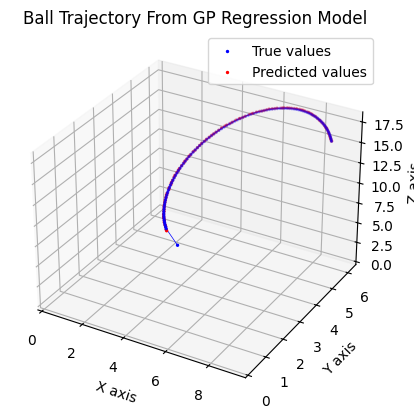

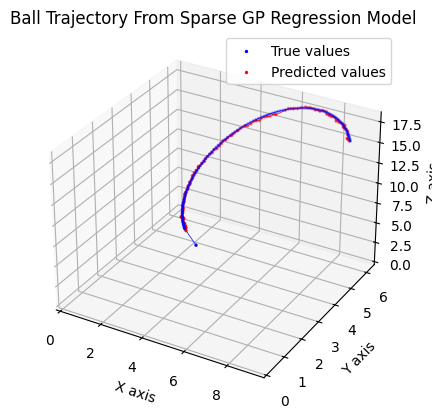

In [23]:
from utils.plot_maker_gaussian_process import plot_maker_3d

plot_maker_3d(y_test, y_pred_reg, "Ball Trajectory From GP Regression Model")
plot_maker_3d(y_test, y_pred_sparse, "Ball Trajectory From Sparse GP Regression Model")

In [24]:
from utils.plot_maker_gaussian_process import gaussian_process_plot

In [25]:
y_var_reg

array([[0.00025159],
       [0.00022004],
       [0.00026121],
       [0.00028769],
       [0.00031243],
       [0.00027633],
       [0.00030135],
       [0.00027955],
       [0.00025052],
       [0.00022622],
       [0.00022997],
       [0.00024346],
       [0.00022145],
       [0.00022644],
       [0.00023996],
       [0.00027292],
       [0.00027739],
       [0.00025601],
       [0.00026368],
       [0.00028193],
       [0.00027694],
       [0.00029558],
       [0.00030638],
       [0.00029973],
       [0.00039284],
       [0.00034981],
       [0.00034918],
       [0.00038799],
       [0.00031244],
       [0.00040667],
       [0.00037682],
       [0.00059782],
       [0.00045807],
       [0.00046294],
       [0.00052477],
       [0.00053648],
       [0.00077895],
       [0.00070739],
       [0.00027267],
       [0.00026655],
       [0.00031043],
       [0.00031889],
       [0.00029386],
       [0.00028648],
       [0.00027819],
       [0.00025973],
       [0.00026638],
       [0.000

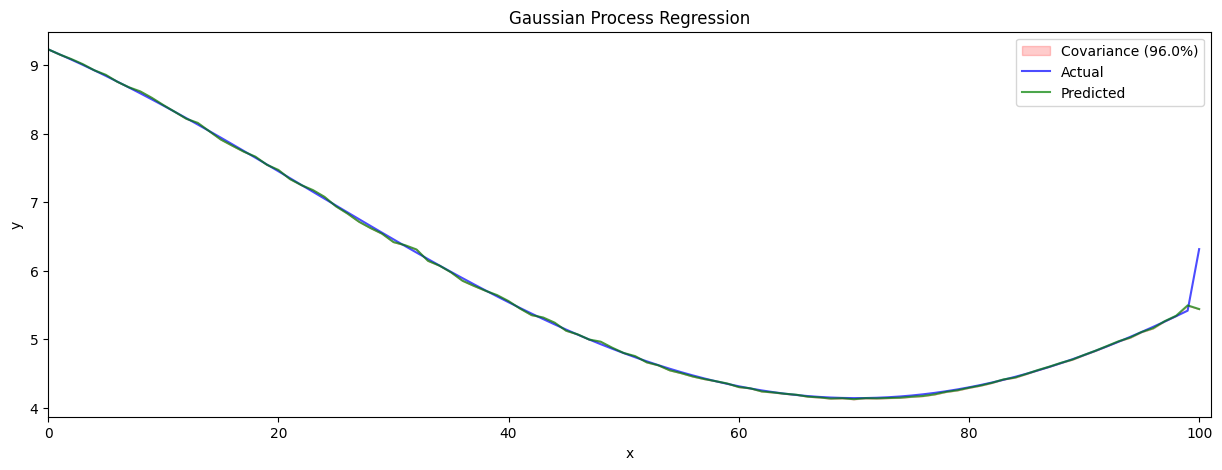

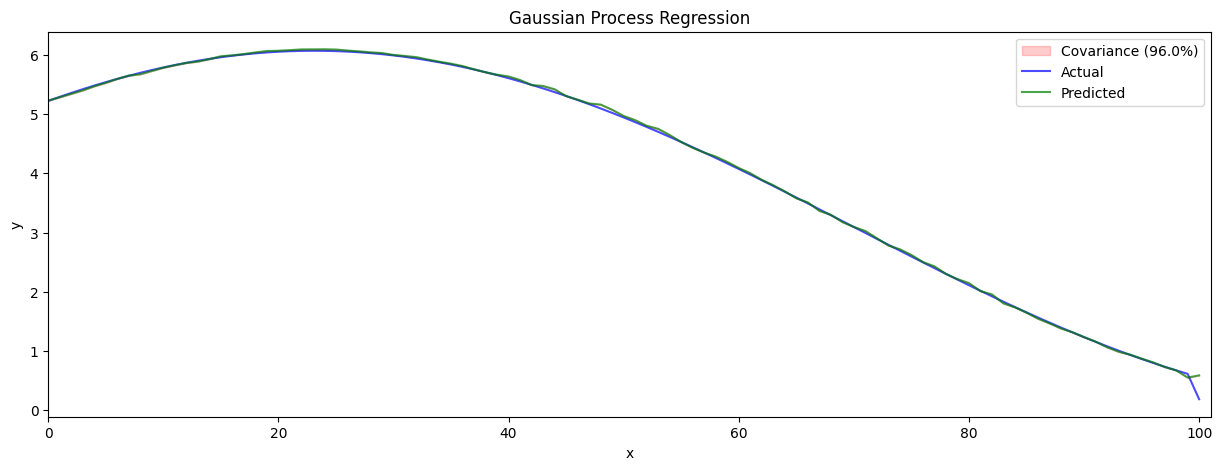

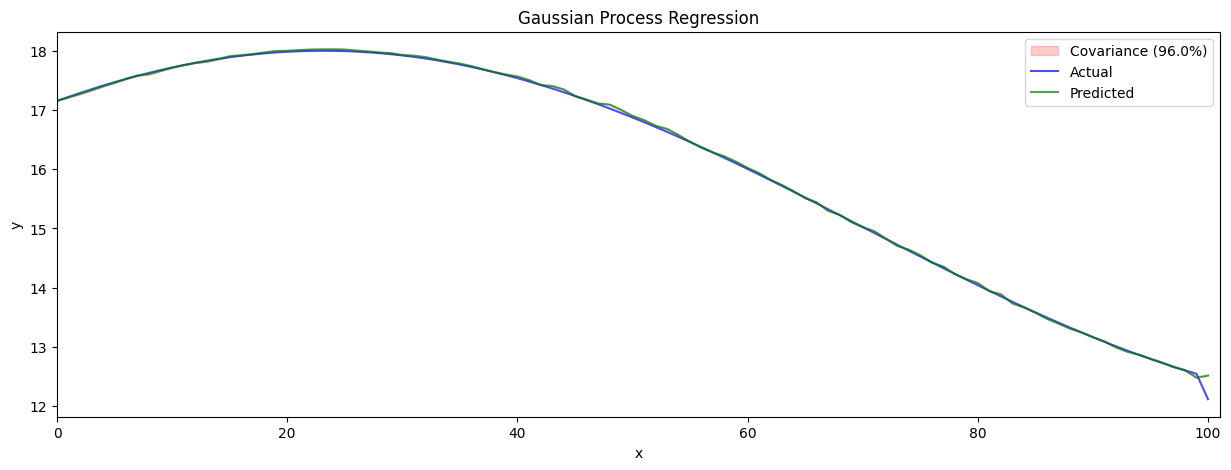

In [26]:
y_pred_reg = np.array(y_pred_reg)
y_test = np.array(y_test)
y_var_reg = np.array(y_var_reg)
y_var_reg = np.mean(y_var_reg, axis=1)

y_pred_x, y_pred_y, y_pred_z = y_pred_reg[:, 0], y_pred_reg[:, 1], y_pred_reg[:, 2]
y_test_x, y_test_y, y_test_z = y_test[:, 0], y_test[:, 1], y_test[:, 2]

gaussian_process_plot(y_test_x, y_pred_x, y_var_reg)
gaussian_process_plot(y_test_y, y_pred_y, y_var_reg)
gaussian_process_plot(y_test_z, y_pred_z, y_var_reg)